In [84]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import math
import pandas as pd

This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks (popularity).<br>
<br>
Reference material <br>
http://benalexkeen.com/feature-scaling-with-scikit-learn/ <br>
https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py <br>
https://archive.ics.uci.edu/ml/datasets/online+news+popularity <br><br>
Target is the last element, shares: Number of shares

In [72]:
# loading of dataset 
dataset = []
labels = []
def load_dataset(is_normalize=True, is_remove_outlier=True):
    global dataset, labels
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader) # skip the first row
        temp_data = []
        temp_label = []
        fields_to_avoid = [0, 9, 12, 13, 14, 15, 16, 17, 21, 30, 31, 32, 33, 34, 35, 36, 37, 51, 
                           8, 10, 21, 34, 38, 39, 41, 60]
        for idx, row in enumerate(reader):            
            slice_row = row[1:-1]
            temp_data.append(slice_row)
            temp_label.append(row[-1])
        
        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))                
    
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.StandardScaler()
            dataset = scaler.fit_transform(dataset)
            # last item uses MinMaxScaler
            labels = np.array(labels).reshape(-1, 1)
            scaler = preprocessing.QuantileTransformer()
            labels = scaler.fit_transform(labels)
            print('Data is normalize')
        else:
            print('No normalize apply')        
            
        if is_remove_outlier:
            dataset, labels = reject_outliers(dataset, labels)        
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def reject_outliers(dataset, labels, m=50):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [135]:
# Splitting of dataset into train and test
# Dataset if normalize using MinMaxScaler
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=True, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

Data is normalize
Outlier removed: 0
Dataset shape: (39644, 59), Labels: (39644, 1)
x_train: (31715, 59), y_train: (31715, 1)
x_test: (7929, 59), y_test: (7929, 1)


Extract and visualise import features using random forest

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


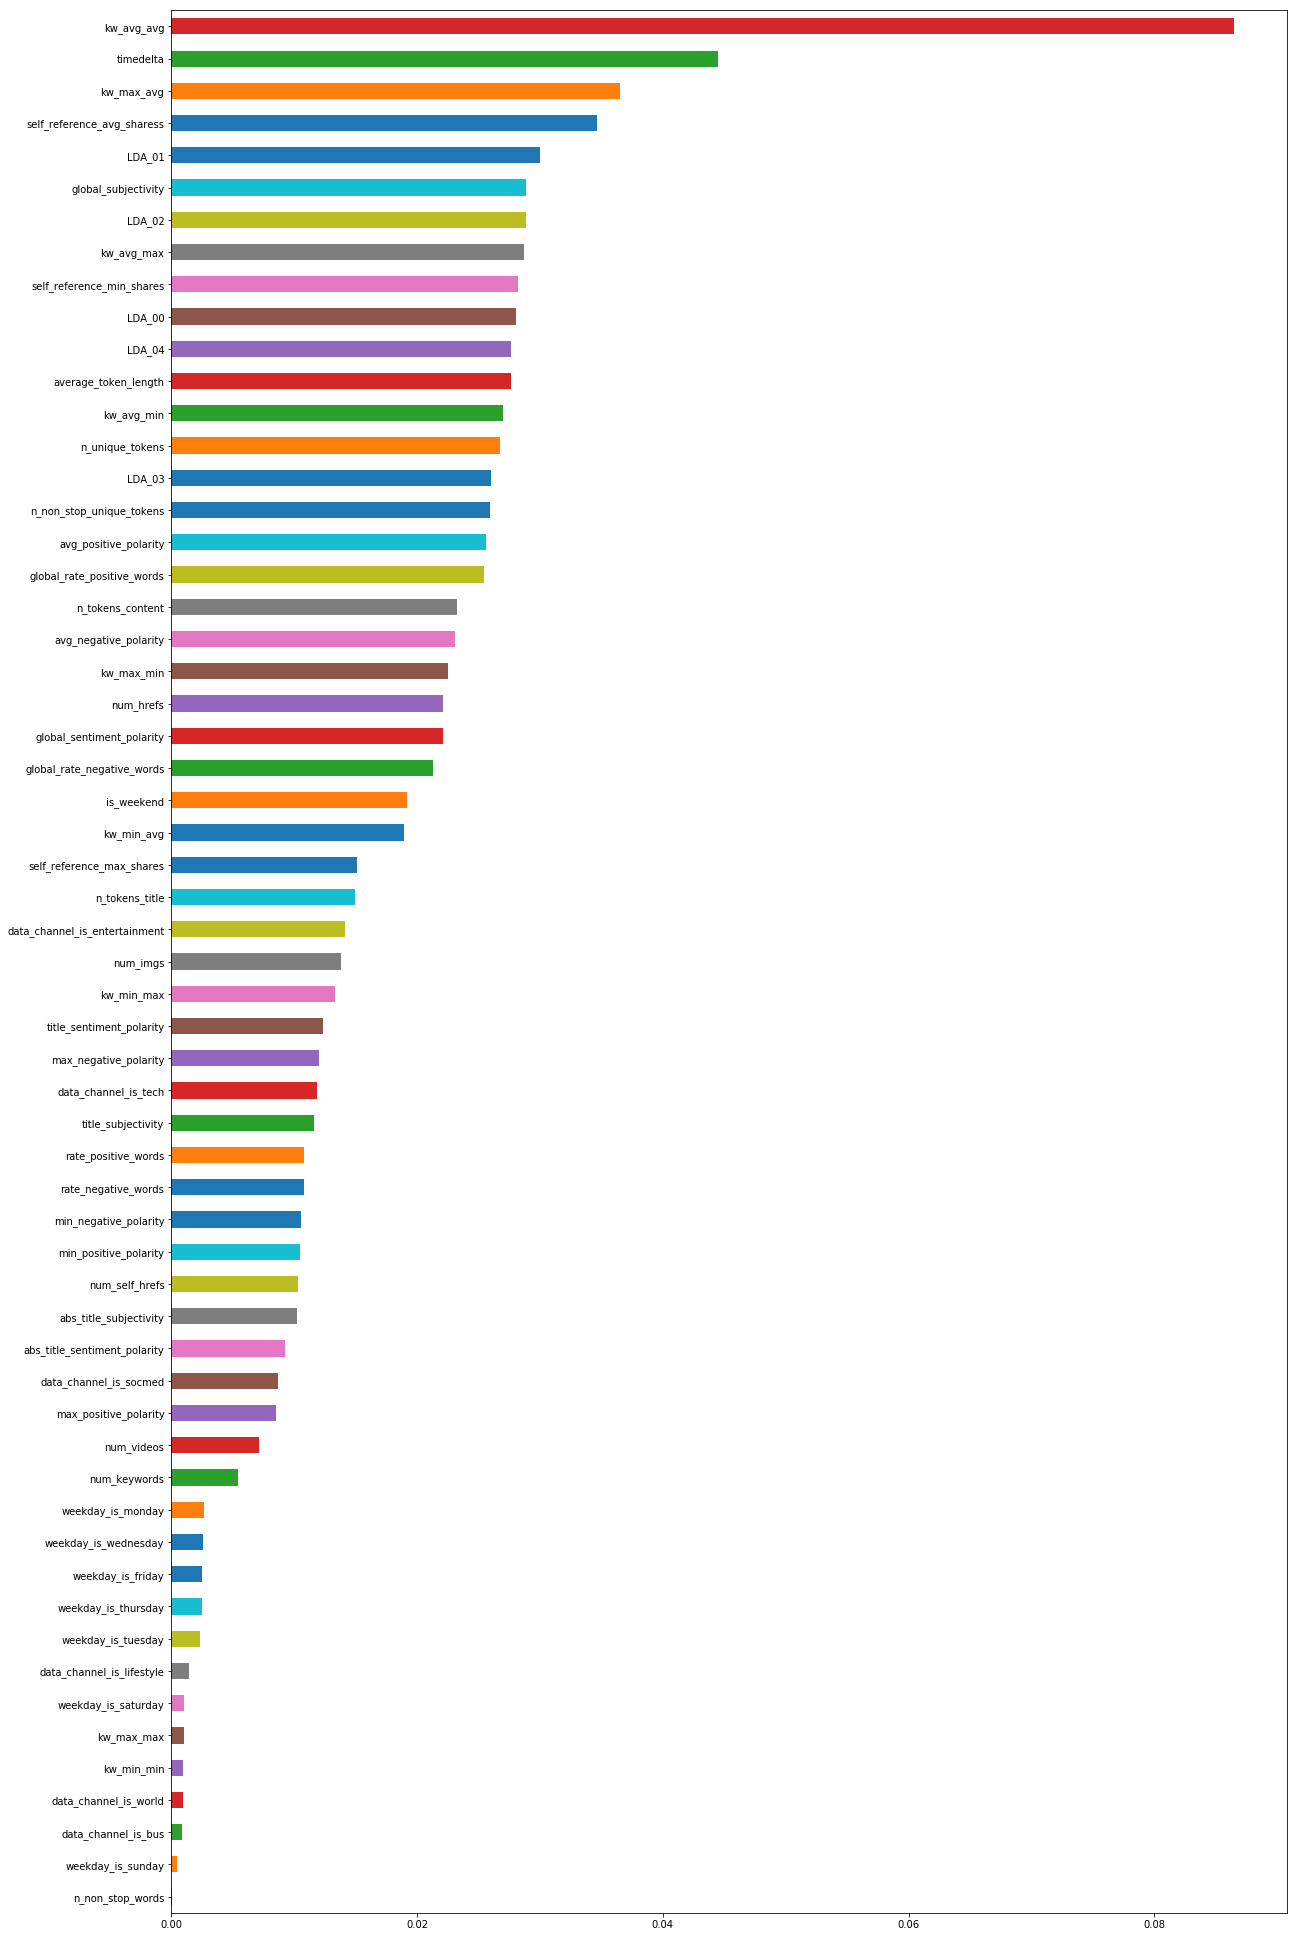

In [136]:
df=pd.read_csv("OnlineNewsPopularity.csv")
df = df.rename(columns = {
       'url': ' url'  
    })
df.rename(columns=lambda x: x[1:], inplace=True)
labels = df.pop('shares')
del df['url']

np.random.seed(100)
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

feature_importances = pd.Series(model.feature_importances_, index=df.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(20,35))

# top 30 headers
headers = ['kw_max_avg', 'self_reference_min_shares', 'kw_avg_avg', 'self_reference_max_shares',
           'self_reference_avg_sharess', 'average_token_length', 'n_unique_tokens', 'timedelta',
           'kw_min_avg', 'n_non_stop_unique_tokens', 'n_tokens_content', 'num_hrefs',
           'global_subjectivity', 'kw_max_min', 'LDA_00', 'LDA_01', 'LDA_04', 'kw_min_max',
           'LDA_03', 'global_rate_negative_words', 'kw_avg_max', 'LDA_02', 'title_subjectivity',
           'n_tokens_title', 'avg_positive_polarity', 'kw_avg_min', 'global_sentiment_polarity',
           'global_rate_positive_words', 'max_negative_polarity', 'title_sentiment_polarity']

dataset = df[headers].copy()
labels = np.array(labels).reshape(len(labels), 1)

# print(x_train[0])
# print(y_train[:10])

In [137]:
scaler = preprocessing.StandardScaler()
dataset = scaler.fit_transform(dataset)

scaler = preprocessing.StandardScaler()
labels = scaler.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=True, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

x_train: (31715, 30), y_train: (31715, 1)
x_test: (7929, 30), y_test: (7929, 1)


c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


dataset (39644, 30)
labels (39644, 1)
Labels max value: 72.2386489166463
Labels min value: -0.2919443858146582
Labels avg value: 1.5772313779358495e-17


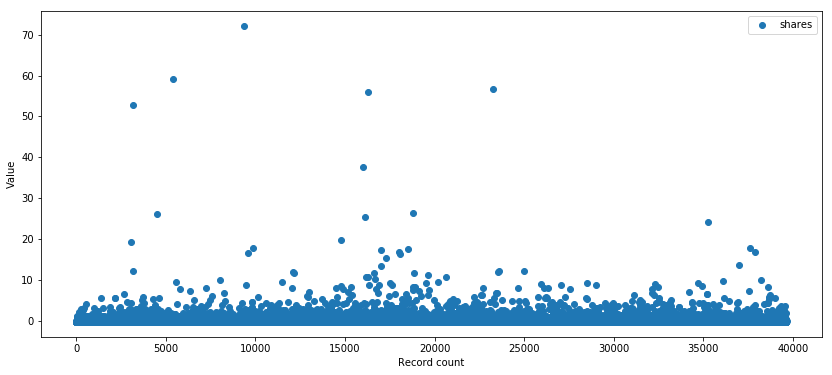

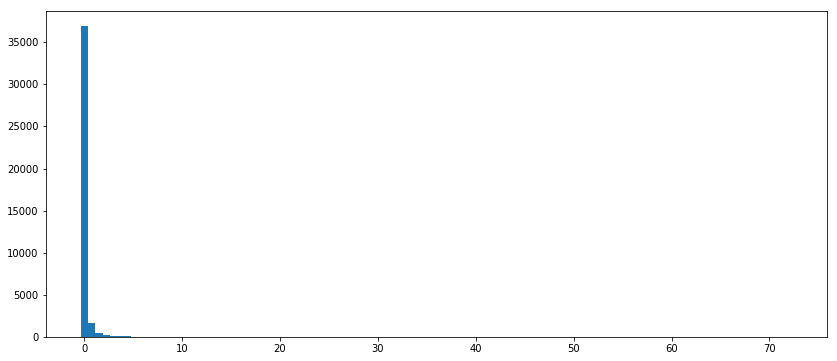

In [138]:
# Quick view of processed datasets
print('dataset {0}'.format(dataset.shape))
print('labels {0}'.format(labels.shape))
print('Labels max value: {0}'.format(np.max(labels)))
print('Labels min value: {0}'.format(np.min(labels)))
print('Labels avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record count")
    plt.ylabel("Value")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

def show_histogram(data):
    plt.figure(figsize=(14,6))
    plt.hist(data, 100)
    plt.show()

show_graph(labels)
show_histogram(labels)

**Reference**<br>
*kernel_regularizer*: Regularizer function applied to the kernel weights matrix (see regularizer).<br>
*activity_regularizer*: Regularizer function applied to the output of the layer (its "activation").

In [128]:
# build model
l2_kernal = 0.001

# model = Sequential()
# model.add(Dense(2048, input_dim=59, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(1024, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Dense(1024, input_dim=30, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mean_squared_error'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 1024)              31744     
_________________________________________________________________
dropout_53 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_54 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_55 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               65792     
__________

In [130]:
# training with callbacks
saved_weights_name = 'best_weights_mlp.h5'

# load weights if any
if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=10,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4,
                              min_lr=0.00001,
                              verbose=1)
    
history = model.fit(x_train, y_train,
                      epochs=50,
                      validation_data=(x_test, y_test),
                      callbacks=[early_stop, checkpoint, reduce_lr],
                      verbose=1)

Train on 31715 samples, validate on 7929 samples
Epoch 1/50
31715/31715 [==============================] - 15s 482us/step - loss: 0.1734 - mean_squared_error: 0.0774 - val_loss: 0.0884 - val_mean_squared_error: 0.0750

Epoch 00001: val_loss improved from inf to 0.08836, saving model to best_weights_mlp.h5
Epoch 2/50
31715/31715 [==============================] - 18s 557us/step - loss: 0.0894 - mean_squared_error: 0.0763 - val_loss: 0.0894 - val_mean_squared_error: 0.0779

Epoch 00002: val_loss did not improve
Epoch 3/50
31715/31715 [==============================] - 17s 550us/step - loss: 0.0888 - mean_squared_error: 0.0763 - val_loss: 0.0871 - val_mean_squared_error: 0.0747

Epoch 00003: val_loss improved from 0.08836 to 0.08709, saving model to best_weights_mlp.h5
Epoch 4/50
31715/31715 [==============================] - 18s 558us/step - loss: 0.0888 - mean_squared_error: 0.0766 - val_loss: 0.0868 - val_mean_squared_error: 0.0745

Epoch 00004: val_loss improved from 0.08709 to 0.0868

31715/31715 [==============================] - 17s 534us/step - loss: 0.0856 - mean_squared_error: 0.0749 - val_loss: 0.0846 - val_mean_squared_error: 0.0741

Epoch 00035: val_loss did not improve
Epoch 36/50
31715/31715 [==============================] - 17s 533us/step - loss: 0.0858 - mean_squared_error: 0.0751 - val_loss: 0.0846 - val_mean_squared_error: 0.0741

Epoch 00036: val_loss did not improve
Epoch 37/50
31715/31715 [==============================] - 17s 541us/step - loss: 0.0857 - mean_squared_error: 0.0750 - val_loss: 0.0846 - val_mean_squared_error: 0.0741

Epoch 00037: val_loss did not improve
Epoch 38/50
31715/31715 [==============================] - 17s 540us/step - loss: 0.0857 - mean_squared_error: 0.0751 - val_loss: 0.0846 - val_mean_squared_error: 0.0740

Epoch 00038: val_loss improved from 0.08461 to 0.08461, saving model to best_weights_mlp.h5
Epoch 39/50
31715/31715 [==============================] - 18s 572us/step - loss: 0.0857 - mean_squared_error: 0.0751 - va

7929/7929 [==============================] - 1s 88us/step
actual max 0.9997412936052874
actual min 0.00042962802644649217
actual median 0.4864864864864865
predict max 0.707678496837616
predict min 0.3624688684940338
predict median 0.4786059558391571

loss: 0.084619
mean_squared_error: 0.074028
root_mse 0.27208
explained_variance_score: -10.641258
mean_absolute_error: 0.232205
mean_squared_log_error: 0.034899
median_absolute_error: 0.227128
r2_score: -10.665494


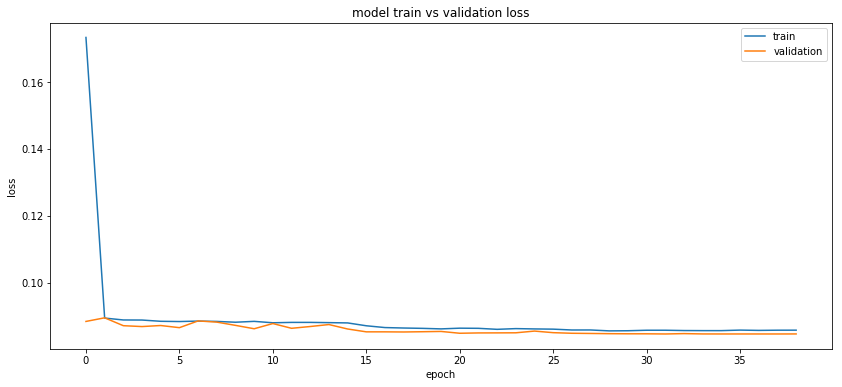

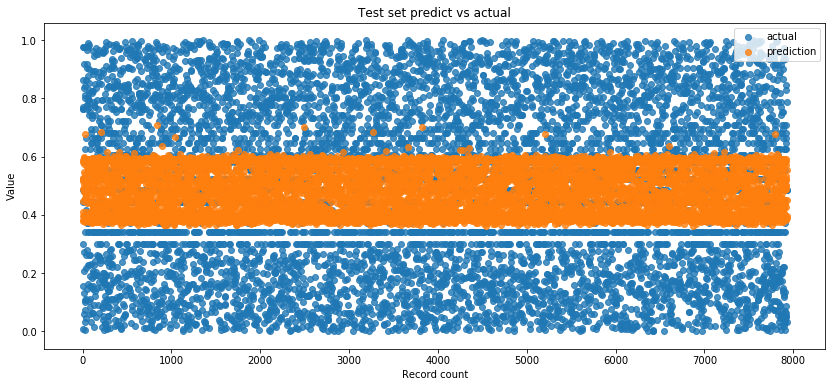

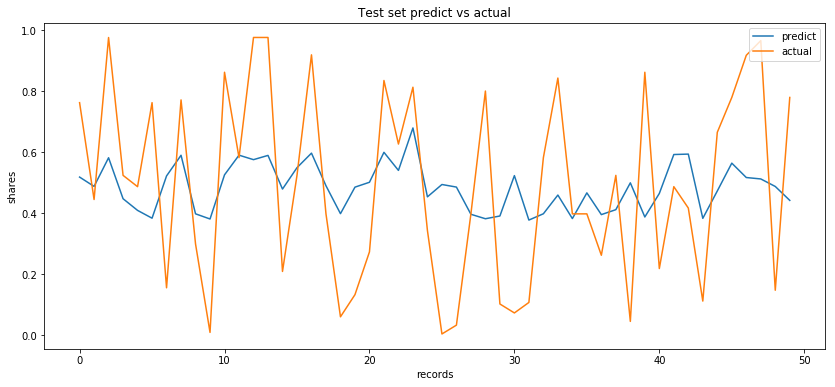

[[0.76176176]
 [0.44444444]
 [0.97517518]
 [0.52352352]
 [0.48648649]
 [0.76176176]
 [0.15515516]
 [0.77077077]
 [0.2987988 ]
 [0.00895348]]
[[0.5179055 ]
 [0.48736975]
 [0.5812452 ]
 [0.4469986 ]
 [0.4087747 ]
 [0.38319796]
 [0.5216175 ]
 [0.58939326]
 [0.39750075]
 [0.38057733]]


In [131]:
# showing results
scores = model.evaluate(x_test, y_test)

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)

root_mse = math.sqrt(scores[1])
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('actual max {0}'.format(np.max(y_test)))
print('actual min {0}'.format(np.min(y_test)))
print('actual median {0}'.format(np.median(y_test)))
print('predict max {0}'.format(np.max(y_pred)))
print('predict min {0}'.format(np.min(y_pred)))
print('predict median {0}'.format(np.median(y_pred)))
print()
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
print('root_mse {0}'.format(round(root_mse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

# plt.figure(figsize=(14,6))
# plt.hist(y_pred, 100)
# plt.hist(y_test, 100)
# plt.show()

plt.figure(figsize=(14,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.xlabel("Record count")
plt.ylabel("Value")
plt.title("Test set predict vs actual")
x = list(range(len(y_pred)))
# plt.ylim(0, 1)
plt.scatter(x, [pt[0] for pt in y_test], label='actual', alpha=0.8)
plt.scatter(x, [pt[0] for pt in y_pred], label='prediction', alpha=0.8)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.title('Test set predict vs actual')
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel('shares')
plt.xlabel('records')
plt.legend(['predict', 'actual'], loc='upper right', borderaxespad=0.5)
plt.show()

print(y_test[:10])
print(y_pred[:10])

In [ ]:
# kfold on dataset and training
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

kfold_result = []

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for train_index, test_index in kf.split(dataset):
    x_train, x_test = dataset[train_index], dataset[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
#     print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
#     print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))
    
    # build model
    model = Sequential()
    model.add(Dense(128, input_dim=58, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(lr=0.001),
                  metrics=['mse'])
    
    # train model
    early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.00001,
                           patience=10,
                           mode='min',
                           verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=4,
                                  min_lr=0.000001,
                                  verbose=1)

    model.fit(x_train, y_train,
              epochs=50,
              validation_data=(x_test, y_test),
              callbacks=[early_stop, reduce_lr],
              verbose=1)
    
    # evaluating model
    scores = model.evaluate(x_test, y_test)
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    y_pred = model.predict(x_test)
    r2 = r2_score(y_pred, y_test)
    print('r2_score: {0}'.format(round(r2, 6)))
    kfold_result.append([scores[0], scores[1], r2])

In [ ]:
avg_loss = 0
avg_mse = 0
avg_r2 = 0

for idx, scores in enumerate(kfold_result):
    avg_loss += scores[0]
    avg_mse += scores[1]
    avg_r2 += scores[2]
    print('kfold {0}'.format(idx+1))
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    print('r2_score: {0}'.format(round(scores[2], 6)))
    print()

print('kfold average loss: {0}'.format(round(avg_loss, 6)))
print('kfold average mse: {0}'.format(round(avg_mse, 6)))
print('kfold average r2: {0}'.format(round((avg_r2/5), 6)))